<a href="https://colab.research.google.com/github/kd-kdev/CognitiveRadio-LSTM/blob/main/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predviđanje stanja kanala uz pomoć LSTM (Long Short-Term Memory) modela
Uz pomoć PyTorch tehnologije, simuliramo više frekventnih kanala kao i njihovu dostupnost kroz vreme.
Koristimo LSTM model koji treniramo na simulaciji jednog spektra i pravimo predviđanja o budućim stanjima spektra na osnovu njegovih prethodnih stanja.

Rad se sastoji iz sledećih delova:
1. Importujemo neophodne biblioteke
2. Simuliramo spektar kao i njegovo stanje kroz vreme koristeći funkciju `simulate_multiple_channels`
3. Pripremamo/obrađujemo podatke u format pogodan za input na LSTM model
4. Definišemo LSTM model
5. Pripremamo DataLoader, spremamo podatke za treniranje
6. Training loop - treniramo model na simuliranim podacima
7. Nasumično odabiramo deo prethodno simuliranih podataka, i predviđamo buduće stanje kanala uz pomoć LSTM modela
8. Proveravamo preciznost modela
9. Poredimo realno stanja kanala sa predviđenim stanjem

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import random

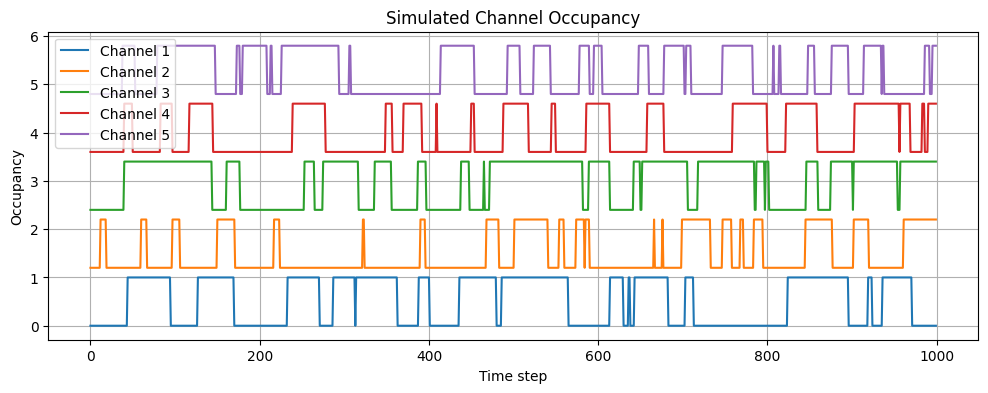

In [ ]:
def simulate_multiple_channels(num_channels=5, length=1000, avg_on_duration=20, avg_off_duration=30):
    channels = []
    for _ in range(num_channels):
        channel = []
        state = 0
        while len(channel) < length:
            duration = np.random.exponential(scale=avg_on_duration if state == 1 else avg_off_duration)
            duration = int(max(1, round(duration)))
            channel.extend([state] * duration)
            state = 1 - state
        channels.append(channel[:length])
    return np.array(channels)

channel_data = simulate_multiple_channels()

# Plot
plt.figure(figsize=(12, 4))
for i in range(channel_data.shape[0]):
    plt.plot(channel_data[i] + i * 1.2, label=f"Channel {i+1}")
plt.title("Simulated Channel Occupancy")
plt.xlabel("Time step")
plt.ylabel("Occupancy")
plt.legend()
plt.grid(True)
plt.show()

Data preparation

In [ ]:
channel_data = channel_data.T # this transposes it to shape (time_steps, num_channels) for sequence slicing

def create_sequence(channel_data, window_size=100, horizon=10):
  X = [] # sequence of past channel states, contains a fixed length window of past observations
  y = [] # sequence of steps after 10 steps (horizon, the num. of steps in the future we want to predict)
  for i in range(len(channel_data) - window_size - horizon +1):
    X.append(channel_data[i:i+window_size])
    y.append(channel_data[i+window_size : i+window_size+horizon])
  return np.array(X), np.array(y)

X, y = create_sequence(channel_data, window_size=100, horizon=10)
print(f"X.shape = {X.shape}, y.shape = {y.shape}")
# will give you 891 training samples from the dataset, 100 time steps, 5 values per channel

X.shape = (891, 100, 5), y.shape = (891, 10, 5)


LSTM model

In [ ]:
class LSTM_model(nn.Module):
  def __init__(self, num_channels, horizon=10, hidden_size=256):
    super().__init__()
    self.horizon = horizon
    self.num_channels = num_channels
    self.lstm = nn.LSTM(input_size=num_channels, hidden_size=hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_channels * horizon)

  def forward(self, x):
    out, _ =self.lstm(x)
    last_out = out[:, -1, :]
    preds = self.fc(last_out)
    preds = preds.view(-1, self.horizon, self.num_channels)
    return torch.sigmoid(preds)

Prepare dataset for training

In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)

batch_size = 64 # try out different values like 32 as well
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Training loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training Parameters
num_channels = X.shape[2]  # 5 channels
horizon = y.shape[1]       # 10 time steps ahead
loss_values = []
epochs = 100
lr = 0.001 # learning rate

model = LSTM_model(num_channels=num_channels, horizon=horizon)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)
criterion = nn.BCELoss()

# Training loop
for epoch in range(1, epochs +1):
  model.train()
  epoch_loss = 0.0

  for X_batch, y_batch in dataloader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    optimizer.zero_grad()
    outputs = model(X_batch)
    loss = criterion(outputs, y_batch)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() * X_batch.size(0)

  avg_loss = epoch_loss / len(dataset)
  loss_values.append(avg_loss)
  print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")

Using device: cuda
Epoch 1/100 - Loss: 0.6775
Epoch 2/100 - Loss: 0.6405
Epoch 3/100 - Loss: 0.6004
Epoch 4/100 - Loss: 0.5555
Epoch 5/100 - Loss: 0.5112
Epoch 6/100 - Loss: 0.4917
Epoch 7/100 - Loss: 0.4489
Epoch 8/100 - Loss: 0.4331
Epoch 9/100 - Loss: 0.4101
Epoch 10/100 - Loss: 0.4029
Epoch 11/100 - Loss: 0.3813
Epoch 12/100 - Loss: 0.3621
Epoch 13/100 - Loss: 0.3446
Epoch 14/100 - Loss: 0.3595
Epoch 15/100 - Loss: 0.3249
Epoch 16/100 - Loss: 0.2910
Epoch 17/100 - Loss: 0.3196
Epoch 18/100 - Loss: 0.3448
Epoch 19/100 - Loss: 0.3071
Epoch 20/100 - Loss: 0.2746
Epoch 21/100 - Loss: 0.2488
Epoch 22/100 - Loss: 0.2306
Epoch 23/100 - Loss: 0.3088
Epoch 24/100 - Loss: 0.3810
Epoch 25/100 - Loss: 0.3271
Epoch 26/100 - Loss: 0.2764
Epoch 27/100 - Loss: 0.2390
Epoch 28/100 - Loss: 0.2130
Epoch 29/100 - Loss: 0.2486
Epoch 30/100 - Loss: 0.3091
Epoch 31/100 - Loss: 0.2572
Epoch 32/100 - Loss: 0.2240
Epoch 33/100 - Loss: 0.2081
Epoch 34/100 - Loss: 0.1861
Epoch 35/100 - Loss: 0.1733
Epoch 36/1

Smallest loss is: 0.0780
Largest loss is: 0.9536
Last loss value is: 0.0920


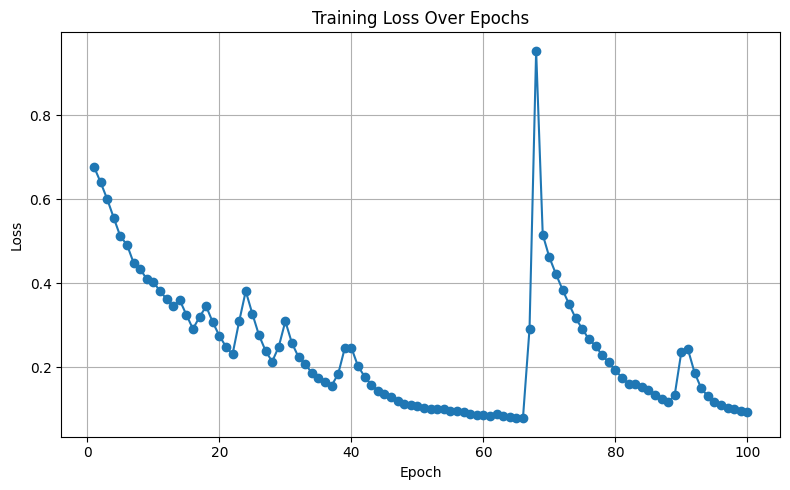

In [ ]:
min_loss_value = min(loss_values)
max_loss_value = max(loss_values)
last_loss_value = loss_values[epochs-1]
print(f"Smallest loss is: {min_loss_value:.4f}")
print(f"Largest loss is: {max_loss_value:.4f}")
print(f"Last loss value is: {last_loss_value:.4f}")
# Loss curve plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluation on sample

In [ ]:
indices = np.arange(len(X))
#np.random.seed(23)  # For reproducibility, comment out for random
np.random.shuffle(indices)
accuracy_values = []

split_idx = int(len(X) * 0.8)  # 80% train, 20% test

train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

train_X = X[train_indices]
train_y = y[train_indices]

test_X = X[test_indices]
test_y = y[test_indices]

# Suppose test_X, test_y are your test numpy arrays prepared similarly to X, y
test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).to(device)

model.eval()
model.to(device)

with torch.no_grad():
    preds = model(test_X_tensor)  # shape: (num_samples, horizon, num_channels)

preds_binary = (preds >= 0.5).int() # converts probabilities to either 1 or 0


correct = (preds_binary == test_y_tensor.int()).sum().item()
total = torch.numel(test_y_tensor)
accuracy = correct / total
print(f"Test accuracy: {accuracy*100:.2f}%")

accuracy_values.append(accuracy * 100)


Test accuracy: 96.99%


Sample data compared with predicted data

In [ ]:
sample_id = random.randint(0, len(test_y_tensor)-1)  # Gets a random sample

# Get tensors for selected sample
actual = test_y_tensor[sample_id].cpu().int().numpy()       # shape: (horizon, num_channels)
predicted = preds_binary[sample_id].cpu().numpy()           # shape: (horizon, num_channels)

# Print comparison per channel
print(f"\nSample Index: {test_indices[sample_id]}")
print(f"X - incorrect prediction")
print(f"O - correct prediction\n")
horizon = actual.shape[0]
num_channels = actual.shape[1]

for ch in range(num_channels):
    actual_str = " ".join(str(actual[t, ch]) for t in range(horizon))
    predicted_str = " ".join(str(predicted[t, ch]) for t in range(horizon))
    correct_str = " ".join("O" if predicted[t, ch] == actual[t, ch] else "X" for t in range(horizon))

    print(f"Channel {ch+1}")
    print(f"Real:      {actual_str}")
    print(f"Predicted: {predicted_str}")
    print(f"Correct:   {correct_str}")
    print()


Sample Index: 20
X - incorrect prediction
O - correct prediction

Channel 1
Real:      0 0 0 0 0 0 0 1 1 1
Predicted: 0 0 0 0 0 0 0 0 1 1
Correct:   O O O O O O O X O O

Channel 2
Real:      0 0 0 0 0 0 0 0 0 0
Predicted: 0 0 0 0 0 0 0 0 0 0
Correct:   O O O O O O O O O O

Channel 3
Real:      1 1 1 1 1 1 1 1 1 1
Predicted: 1 1 1 1 1 1 1 1 1 1
Correct:   O O O O O O O O O O

Channel 4
Real:      1 1 1 1 1 1 1 1 1 1
Predicted: 1 1 1 1 1 1 1 1 1 1
Correct:   O O O O O O O O O O

Channel 5
Real:      1 1 1 1 1 1 1 1 1 1
Predicted: 1 1 1 1 1 1 1 1 1 1
Correct:   O O O O O O O O O O

